In [1]:
import os
import glob
import pandas as pd
import numpy as np
import json
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer

import pickle

from collections import Counter
from notebook_utils import initialize_environment
initialize_environment()

from utils.data_loading.load_data import get_tile_data

from sklearn.feature_extraction.text import TfidfVectorizer
from ast import literal_eval

import torch.cuda
import torch.nn as nn
import torch.nn.functional as F

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
data_directory = "../data/context_data/"
json_directory = "../data/json_files_trimmed_features/"

game_data_path="../data/game_data.csv"
train_data_path="../data/train_data.csv"
test_data_path="../data/test_data.csv"

EPOCHS=10
BATCH_SIZE=25
LATENT_DIM=256

In [3]:
# data loading

def get_pickle_file(path):
    with open(path,"rb") as handle:
        return pickle.load(handle)

data=pd.read_csv(game_data_path)
train_data=pd.read_csv(train_data_path)
test_data=pd.read_csv(test_data_path)

data['features'] = data.features.apply(lambda x: literal_eval(str(x)))
train_data['features'] = train_data.features.apply(lambda x: literal_eval(str(x)))
test_data['features'] = test_data.features.apply(lambda x: literal_eval(str(x)))

# loading multi-label binarizer
mlb=get_pickle_file("../model/model_tokenizer.pickle")
print("Feature Dictionary Loaded")
total_features = len(mlb.classes_)
print("The feature dictionary has size", total_features)
display("Features", mlb.classes_)

# loading the batches
# training 
train_image_batch=get_pickle_file("../data/train_image_batch.pickle")
train_text_batch=get_pickle_file("../data/train_text_batch.pickle")
output_image_batch=get_pickle_file("../data/output_image_batch.pickle")
output_text_batch=get_pickle_file("../data/output_text_batch.pickle")

#testing
test_image_batch=get_pickle_file("../data/test_image_batch.pickle")
test_text_batch=get_pickle_file("../data/test_text_batch.pickle")

print("Training Testing Batches loaded")

print("Train Image batch shape", train_image_batch.shape)
print("Train Text batch shape", train_text_batch.shape)
print("Train Output Image batch shape", output_image_batch.shape)
print("Train Output Text batch shape", output_text_batch.shape)

print("Test Image batch shape", test_image_batch.shape)
print("Test Text batch shape", test_text_batch.shape)   

Feature Dictionary Loaded
The feature dictionary has size 13


'Features'

array(['block', 'breakable', 'climbable', 'collectable', 'element',
       'empty', 'hazard', 'moving', 'openable', 'passable', 'pipe',
       'solid', 'wall'], dtype=object)

\Training Testing Batches loaded
Train Image batch shape (22854, 48, 48, 3)
Train Text batch shape (22854, 13)
Train Output Image batch shape (22854, 16, 16, 3)
Train Output Text batch shape (22854, 13)
Test Image batch shape (2540, 48, 48, 3)
Test Text batch shape (2540, 13)


In [6]:
train_data.head()

,Unnamed: 0,game_identifier,image_path,centre_tile,context_string,features
0,21790,lode_runner,../data/context_data/lode_runner/B/@@EBBB .png,B,@@EBBB,[solid]
1,12115,lode_runner,../data/context_data/lode_runner/@/#@b#@@bbb.png,@,#@b#@@bbb,"[passable, empty]"
2,15571,lode_runner,../data/context_data/lode_runner/E/@@@#EbB##.png,E,@@@#EbB##,"[solid, hazard]"
3,24113,smb,../data/context_data/smb/-/o--------.png,-,o--------,"[passable, empty]"
4,104,megaman,../data/context_data/megaman/#/##@##@--@.png,#,##@##@--@,[solid]


In [7]:
train_data_copy = train_data
train_data_copy["features"] = train_data_copy.features.apply(lambda x: str(x))
train_data_copy.head()

,Unnamed: 0,game_identifier,image_path,centre_tile,context_string,features
0,21790,lode_runner,../data/context_data/lode_runner/B/@@EBBB .png,B,@@EBBB,['solid']
1,12115,lode_runner,../data/context_data/lode_runner/@/#@b#@@bbb.png,@,#@b#@@bbb,"['passable', 'empty']"
2,15571,lode_runner,../data/context_data/lode_runner/E/@@@#EbB##.png,E,@@@#EbB##,"['solid', 'hazard']"
3,24113,smb,../data/context_data/smb/-/o--------.png,-,o--------,"['passable', 'empty']"
4,104,megaman,../data/context_data/megaman/#/##@##@--@.png,#,##@##@--@,['solid']


In [4]:
#initialise the TF-IDF vectorizer to counter imbalanced dataset
vectorizer = TfidfVectorizer(stop_words=None)
train_data_copy = train_data
train_data_copy["features"] = train_data_copy.features.apply(lambda x: str(x))
vectors = vectorizer.fit_transform(train_data_copy["features"])
idf = vectorizer.idf_
new_dict = {}
for c in mlb.classes_:
    if c in vectorizer.vocabulary_.keys():
        new_dict[c] = idf[vectorizer.vocabulary_[c]]
    else:
        new_dict[c] = np.max(idf)
print("\n Printing the TF-IDF for the labels\n\n", new_dict)
weight_freq = {k: v / sum(new_dict.values()) for k, v in new_dict.items()}
print("\nPrinting the weight normalised\n\n")
print(weight_freq)
weight_vector = [v * 1000 for v in new_dict.values()]
tensor_from_list = torch.tensor(weight_vector)
tensor_from_list = tensor_from_list.type(torch.float32)
print("Weight Vector")
print(weight_vector)


 Printing the TF-IDF for the labels

 {'block': 5.08368185647806, 'breakable': 2.5970451024522774, 'climbable': 2.761548815929438, 'collectable': 4.099611109542163, 'element': 5.56465451709437, 'empty': 2.0965579574606696, 'hazard': 4.8084141871746615, 'moving': 6.184894926846227, 'openable': 6.411952377481573, 'passable': 1.603201296270845, 'pipe': 6.53711552043558, 'solid': 1.827785539366181, 'wall': 5.268604194972072}

Printing the weight normalised


{'block': 0.09269168764552638, 'breakable': 0.04735239148199231, 'climbable': 0.050351817342350516, 'collectable': 0.07474894833349648, 'element': 0.10146134886401398, 'empty': 0.038226919152316914, 'hazard': 0.08767268261289057, 'moving': 0.11277030405612387, 'openable': 0.11691028348167781, 'passable': 0.029231458219100986, 'pipe': 0.1191924056283738, 'solid': 0.033326343205771214, 'wall': 0.0960634099763652}
Weight Vector
[5083.681856478061, 2597.045102452277, 2761.548815929438, 4099.611109542163, 5564.65451709437, 2096.55795746066

In [5]:
class WeightedBCE(nn.Module):

    def __init__(self, weightedArray, debug=False):
        super().__init__()

        self.debug = debug

        self.weighedArray = weightedArray

    def forward(self, yPred, yTrue):

        bce_array = nn.functional.binary_cross_entropy(yPred, yTrue, reduction="none")
        weighted_array = torch.mul(bce_array, self.weighedArray)

        if self.debug:
            print(weighted_array.shape)

        bce_sum = torch.sum(weighted_array, axis=1)
        loss = torch.div(bce_sum, 13.0)
        loss = torch.mean(loss)

        return loss

In [25]:
criterion = WeightedBCE(tensor_from_list)

torch.manual_seed(0)

tensor1 = torch.randint(0, 2, size=(4, 13), dtype=torch.float32)
tensor2 = torch.randint(0, 2, size=(4, 13), dtype=torch.float32)

loss = criterion(tensor1, tensor2)
print(loss)

torch.Size([4, 13])
tensor(218301.7031)


In [6]:
criterion = nn.MSELoss()

torch.manual_seed(0)

tensor1 = torch.randint(0, 255, size=(4, 3, 48, 48), dtype=torch.float32)
tensor2 = torch.randint(0, 255, size=(4, 3, 48, 48), dtype=torch.float32)

loss = criterion(tensor1, tensor2)
print(loss)

tensor(10830.4111)


In [6]:
class TileEmbeddingVAE(nn.Module):

    def __init__(self, debug=False):
        super().__init__()

        self.debug = debug

        self.imageEncoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=3),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.Flatten(),
        )

        self.textEncoder = nn.Sequential(
            nn.Linear(13, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
        )

        self.embeddingLayer = nn.Linear(4112, 256)

        self.imageDecoder = nn.Sequential(
            nn.Linear(256, 4096),
            nn.Unflatten(1, (16, 16, 16)),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
        )

        self.textDecoder = nn.Sequential(
            nn.Linear(256, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 13),
            nn.Sigmoid(),
        )

    def encode(self, xImages, xText):
        encodedImage = self.imageEncoder(xImages)
        encodedText = self.textEncoder(xText)

        if self.debug:
            print("EncodedImage shape: ", encodedImage.shape)
            print("encodedText shape: ", encodedText.shape)

        concatenateEmbeddding = torch.cat((encodedImage, encodedText), 1)

        embedding = self.embeddingLayer(concatenateEmbeddding)

        return embedding

    def decode(self, embedding):
        decodedImage = self.imageDecoder(embedding)
        decodedText = self.textDecoder(embedding)
        return decodedImage, decodedText

    def forward(self, xImages, xText):
        # Encoder
        encodedEmbedding = self.encode(xImages, xText)

        # Decoder
        yPredImage, yPredText = self.decode(encodedEmbedding)
        
        return yPredImage, yPredText

In [8]:
images = torch.tensor(np.random.randint(0, 255, size=(2, 3, 48, 48))).type(torch.float32)
yImages = images[:, :, 16:32, 16:32]
print(images.shape)
print(yImages.shape)

texts = torch.tensor(np.random.randint(0, 2, size=(2, 13))).type(torch.float32)
print(texts.shape)

imageCrit = nn.MSELoss()
textCrit = WeightedBCE(tensor_from_list)

model = TileEmbeddingVAE()
yPredImages, yPredText = model(images, texts)

imageLoss = imageCrit(yPredImages, yImages)
textLoss = textCrit(yPredText, texts)

torch.Size([2, 3, 48, 48])
torch.Size([2, 3, 16, 16])
torch.Size([2, 13])


In [10]:
imageInputTorch = torch.tensor(np.random.randint(0, 255, size=(3, 3, 48, 48)), dtype=torch.float32)
textInputTorch = torch.tensor(np.random.randint(0, 2, size=(3, 13)), dtype=torch.float32)

model = TileEmbeddingVAE()

outputImagesTorch, outputTextTorch = model(imageInputTorch, textInputTorch)
outputImagesTorch = outputImagesTorch.detach().numpy()
outputTextTorch = outputTextTorch.detach().numpy()
print(outputImagesTorch.shape)
print(outputTextTorch.shape)

EncodedImage shape:  torch.Size([3, 4096])
encodedText shape:  torch.Size([3, 16])
(3, 3, 16, 16)
(3, 13)


In [19]:
for i, (name, layer) in enumerate(model.named_parameters()):
    print(f"layer {name}: | {layer.data.shape}")

layer imageEncoder.0.weight: | torch.Size([32, 3, 3, 3])
layer imageEncoder.0.bias: | torch.Size([32])
layer imageEncoder.1.weight: | torch.Size([32])
layer imageEncoder.1.bias: | torch.Size([32])
layer imageEncoder.3.weight: | torch.Size([32, 32, 3, 3])
layer imageEncoder.3.bias: | torch.Size([32])
layer imageEncoder.4.weight: | torch.Size([32])
layer imageEncoder.4.bias: | torch.Size([32])
layer imageEncoder.6.weight: | torch.Size([16, 32, 3, 3])
layer imageEncoder.6.bias: | torch.Size([16])
layer imageEncoder.7.weight: | torch.Size([16])
layer imageEncoder.7.bias: | torch.Size([16])
layer textEncoder.0.weight: | torch.Size([32, 13])
layer textEncoder.0.bias: | torch.Size([32])
layer textEncoder.2.weight: | torch.Size([16, 32])
layer textEncoder.2.bias: | torch.Size([16])
layer embeddingLayer.weight: | torch.Size([256, 4112])
layer embeddingLayer.bias: | torch.Size([256])
layer imageDecoder.0.weight: | torch.Size([4096, 256])
layer imageDecoder.0.bias: | torch.Size([4096])
layer imag

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TileEmbeddingVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

imageCritierion = nn.MSELoss()
textCritierion = WeightedBCE(tensor_from_list.to(device))

In [49]:
batchSize = 32
epochs = 10

imageLossWeight = 0.8
textLossWeight = 1.0 - imageLossWeight

model.to(device)
model.train()

for i in range(epochs):

    losses = []

    for j in range(0, len(train_image_batch), batchSize):

        xImages = train_image_batch[j:j+batchSize]
        yImages = xImages[:, 16:32, 16:32, :]
        # print(xImages.shape)
        # print(yImages.shape)

        xImageBatch = torch.tensor(xImages, dtype=torch.float32)
        xImageBatch = xImageBatch.reshape((-1, 3, 48, 48))
        xImageBatch = xImageBatch.to(device)

        yImageBatch = torch.tensor(yImages, dtype=torch.float32)
        yImageBatch = yImageBatch.reshape((-1, 3, 16, 16))
        yImageBatch = yImageBatch.to(device)

        xTextbatch = torch.tensor(train_text_batch[j:j+batchSize], dtype=torch.float32).to(device)

        yPredImages, yPredTexts = model(xImageBatch, xTextbatch)
        # print(yPredImages.shape)
        # print(yImageBatch.shape)

        imageLoss = imageCritierion(yPredImages, yImageBatch)
        textLoss = textCritierion(yPredTexts, xTextbatch)
        # print(imageLoss)
        # print(textLoss)

        loss = torch.add(torch.mul(imageLoss, imageLossWeight), torch.mul(textLoss, textLossWeight))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().item())

    print(f"Epoch {i}: loss {sum(losses)/len(losses)}")

Epoch 0: loss 2851.6606394094188
Epoch 1: loss 1775.5113432344024
Epoch 2: loss 1169.3082015884506
Epoch 3: loss 809.1266747107873
Epoch 4: loss 550.5015021050726
Epoch 5: loss 378.29876796482324
Epoch 6: loss 275.74297955919815
Epoch 7: loss 211.5720647745199
Epoch 8: loss 168.90149171202333
Epoch 9: loss 145.6778949337406


In [39]:
print(imageLoss)
print(textLoss)
print(textLoss.shape)
p1 = torch.mul(imageLoss, imageLossWeight)
print("p1: ", p1)
p2 = torch.mul(textLoss, textLossWeight)
print("p2: ", p2)
loss = torch.mul(imageLoss, imageLossWeight) + (textLoss * textLossWeight)
print(loss)

tensor(5767.1675, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(135.8133, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([])
p1:  tensor(4613.7339, device='cuda:0', grad_fn=<MulBackward0>)
p2:  tensor(27.1627, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4640.8965, device='cuda:0', grad_fn=<AddBackward0>)


In [41]:
a = glob.glob("../data/unified_rep/loz/*")

embeddings = []
for filePath in a:
    with open(filePath, "rb") as f:
        level = pickle.load(f)
        for tile in level:
            for t in tile:
                embeddings.append(t)

embeddings = np.array(embeddings)

In [43]:
embeddings = embeddings[:10000]

In [45]:
# t-SNE to visualize embedding space
tsne = TSNE(n_components=2)
fitEmbeddings = tsne.fit_transform(embeddings)

In [51]:
print(fitEmbeddings.shape)

(10000, 2)


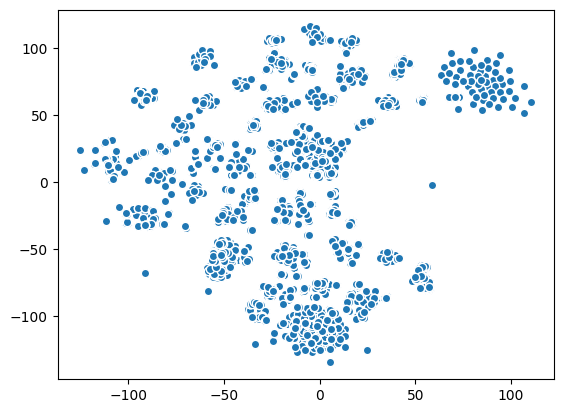

In [54]:
plt.scatter(fitEmbeddings[:,0], fitEmbeddings[:,1], edgecolors='white')

In [27]:
class TestModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer1 = nn.Conv2d(3, 32, kernel_size=3, stride=3)
        self.layer2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.layer3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.flattenLayer = nn.Flatten()
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.batchNorm3 = nn.BatchNorm2d(16)
        pass

    def forward(self, x):
        print("In Forward!")
        x = self.layer1(x)
        x = self.batchNorm1(x)
        x = nn.functional.relu(x)
        print(x.shape)

        x = self.layer2(x)
        x = self.batchNorm2(x)
        x = nn.functional.relu(x)
        print(x.shape)

        x = self.layer3(x)
        x = self.batchNorm3(x)
        x = nn.functional.relu(x)
        print(x.shape)

        x = self.flattenLayer(x)
        print(x.shape)

        return x

images = torch.tensor(np.random.randint(0, 255, size=(2, 3, 48, 48))).type(torch.float32)
print(images.shape)

model = TestModel()
model(images)

torch.Size([2, 3, 48, 48])
In Forward!
torch.Size([2, 32, 16, 16])
torch.Size([2, 32, 16, 16])
torch.Size([2, 16, 16, 16])
torch.Size([2, 4096])


tensor([[0.0000, 0.4615, 0.0000,  ..., 0.4742, 0.0000, 0.3100],
        [1.0771, 2.1234, 0.3187,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)